<a href="https://colab.research.google.com/github/robertchoi/BatteryDatasetImplementation/blob/master/%EB%AA%A8%EB%8D%B81_5%EC%9D%BC_10%EC%9D%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from keras.layers import RNN
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import layers, models
from sklearn import preprocessing
from keras import datasets
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn import model_selection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pykalman

In [ ]:
forecasting = 20

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0222_20110307012737_cell_1.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,1,0.259,2.23,-20
1,2011.3.7 18:29,1,0.260,2.23,-20
2,2011.3.8 6:29,1,0.259,2.23,-20
3,2011.3.8 18:29,1,0.259,2.23,-20
4,2011.3.9 6:29,1,0.259,2.23,-20
...,...,...,...,...,...
254,2011.8.30 5:28,1,0.301,2.23,-20
255,2011.8.30 17:28,1,0.301,2.23,-20
256,2011.8.31 5:28,1,0.302,2.23,-20
257,2011.8.31 16:09,1,0.300,2.23,-20


In [ ]:
df = df.drop(['CellNo', 'MeasuredDate'], axis=1)
df

,Resistance,Volt,Temp
0,0.259,2.23,-20
1,0.260,2.23,-20
2,0.259,2.23,-20
3,0.259,2.23,-20
4,0.259,2.23,-20
...,...,...,...
254,0.301,2.23,-20
255,0.301,2.23,-20
256,0.302,2.23,-20
257,0.300,2.23,-20


In [ ]:
from pykalman import KalmanFilter

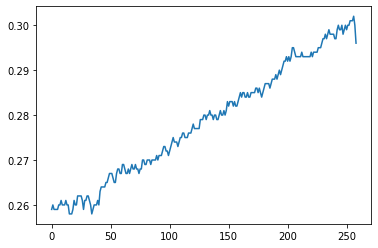

In [ ]:
df['Resistance'].plot()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
train = df_scaled

In [ ]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]

In [ ]:
type(train_feature)

pandas.core.frame.DataFrame

In [ ]:
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)


In [ ]:
x_train[0]

array([[0.        , 0.        , 0.02272727],
       [0.        , 0.        , 0.06818182],
       [0.        , 0.        , 0.04545455],
       [0.        , 0.        , 0.04545455],
       [0.        , 0.        , 0.09090909],
       [0.        , 0.        , 0.09090909],
       [0.        , 0.        , 0.09090909],
       [0.        , 0.        , 0.09090909],
       [0.        , 0.        , 0.06818182],
       [0.        , 0.        , 0.02272727],
       [0.        , 0.        , 0.06818182],
       [0.        , 0.        , 0.06818182],
       [0.        , 0.        , 0.09090909],
       [0.        , 0.        , 0.09090909],
       [0.        , 0.        , 0.06818182],
       [0.        , 0.        , 0.04545455],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.02272727],
       [0.        , 0.        , 0.04545455],
       [0.        , 0.        , 0.04545455]])

In [ ]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P

In [ ]:
A = 1
H = 1
Q = 0.00001
R = 0.001

x_0 = 0.259
P_0 = 2

In [ ]:
n_samples = len(df)

In [ ]:
x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(x_train, x_esti, P)
        # print(x_esti[1])
print("123", x_esti)
    # x_train[i] = x_esti

In [ ]:
y_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(y_train, y_esti, P)
        # print(y_esti)

In [ ]:
model = Sequential()
model.add(LSTM(30, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(3))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('C:/Users/wlsrm/data', 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_esti, y_esti, 
                    epochs=1000, 
                    batch_size=16)

In [ ]:
def mse(label, pred, length):
  for i in range(length):
    error_avg = 0
    error = abs((label[i]-pred[i])/ label[i]*100)
    error_avg = error + error
    return error_avg / length

In [ ]:
new_forecasting= 20

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting


test = test.iloc[0:seq,:]

feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None

for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)

look_ahead=new_forecasting
xhat = x_esti[0]
predictions = np.zeros((seq, 3))

for i in range(seq):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

pred3 = list(pred2)
label_List = list(label)


for i in range(seq):
    error_avg = 0
    error = abs((label_List[i]-pred3[i])/ label_List[i]*100)
    error_avg = error + error
print((error_avg/seq)*100)



plt.figure(figsize=(12,5))
plt.plot(label,label="actual")
plt.plot(pred2,label="pre")
# plt.plot(x_esti,label="x_esti")
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting


test = test.iloc[0:seq,:]

feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)
# print(x_esti[0])

look_ahead=new_forecasting
xhat = x_esti[0]
predictions = np.zeros((seq, 3))
for i in range(seq):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

pred3 = list(pred2)
label_List = list(label)


for i in range(seq):
    error_avg = 0
    error = abs((label_List[i]-pred3[i])/ label_List[i]*100)
    error_avg = error + error
print("MSE = ",error_avg/seq)



plt.figure(figsize=(12,5))
plt.plot(label,label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting


test = test.iloc[0:seq,:]

feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)
# print(x_esti[0])

x = []
print(type(x))
look_ahead=new_forecasting
xhat = x_esti[0]
predictions = np.zeros((seq, 3))
for i in range(seq):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

pred3 = list(pred2)
label_List = list(label)


for i in range(seq):
    error_avg = 0
    error = abs((label_List[i]-pred3[i])/ label_List[i]*100)
    error_avg = error + error
print(error_avg/seq)



plt.figure(figsize=(12,5))
plt.plot(label,label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting


test = test.iloc[0:seq,:]

feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)
# print(x_esti[0])

x = []
print(type(x))
look_ahead=new_forecasting
xhat = x_esti[0]
predictions = np.zeros((seq, 3))
for i in range(seq):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

pred3 = list(pred2)
label_List = list(label)


for i in range(seq):
    error_avg = 0
    error = abs((label_List[i]-pred3[i])/ label_List[i]*100)
    error_avg = error + error
print(error_avg/seq)



plt.figure(figsize=(12,5))
plt.plot(label,label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting


test = test.iloc[0:seq,:]

feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)
# print(x_esti[0])

x = []
print(type(x))
look_ahead=new_forecasting
xhat = x_esti[0]
predictions = np.zeros((seq, 3))
for i in range(seq):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

pred3 = list(pred2)
label_List = list(label)


for i in range(seq):
    error_avg = 0
    error = abs((label_List[i]-pred3[i])/ label_List[i]*100)
    error_avg = error + error
print(error_avg/seq)



plt.figure(figsize=(12,5))
plt.plot(label,label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting


test = test.iloc[0:seq,:]

feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)
# print(x_esti[0])

x = []
print(type(x))
look_ahead=new_forecasting
xhat = x_esti[0]
predictions = np.zeros((seq, 3))
for i in range(seq):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

pred3 = list(pred2)
label_List = list(label)


for i in range(seq):
    error_avg = 0
    error = abs((label_List[i]-pred3[i])/ label_List[i]*100)
    error_avg = error + error
print(error_avg/seq)



plt.figure(figsize=(12,5))
plt.plot(label,label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting


test = test.iloc[0:seq,:]

feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)
# print(x_esti[0])

x = []
print(type(x))
look_ahead=new_forecasting
xhat = x_esti[0]
predictions = np.zeros((seq, 3))
for i in range(seq):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

pred3 = list(pred2)
label_List = list(label)


for i in range(seq):
    error_avg = 0
    error = abs((label_List[i]-pred3[i])/ label_List[i]*100)
    error_avg = error + error
print(error_avg/seq)



plt.figure(figsize=(12,5))
plt.plot(label,label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')
# print(test_df)
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting


test = test.iloc[0:seq,:]

feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)
# print(x_esti[0])

x = []
print(type(x))
look_ahead=new_forecasting
xhat = x_esti[0]
predictions = np.zeros((seq, 3))
for i in range(seq):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

pred3 = list(pred2)
label_List = list(label)


for i in range(seq):
    error_avg = 0
    error = abs((label_List[i]-pred3[i])/ label_List[i]*100)
    error_avg = error + error
print(error_avg/seq)



plt.figure(figsize=(12,5))
plt.plot(label,label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')

scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting


test = test.iloc[0:seq,:]

feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)
# print(x_esti[0])

x = []
print(type(x))
look_ahead=new_forecasting
xhat = x_esti[0]
predictions = np.zeros((seq, 3))
for i in range(seq):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

pred3 = list(pred2)
label_List = list(label)


for i in range(seq):
    error_avg = 0
    error = abs((label_List[i]-pred3[i])/ label_List[i]*100)
    error_avg = error + error
print(error_avg/seq)



plt.figure(figsize=(12,5))
plt.plot(label,label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
pred2

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(label,label="actual")
# plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()